In [ ]:
!rm -r /content/sample_data/

In [ ]:
!mkdir -p /content/dataset/original/Questions
!mkdir -p /content/dataset/original/Annotations
!mkdir -p /content/dataset/original/Images

!mkdir -p /content/dataset/preprocessed/Questions
!mkdir -p /content/dataset/preprocessed/Annotations
!mkdir -p /content/dataset/preprocessed/Images

In [ ]:
# Annotations 
!wget https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Annotations_Train_mscoco.zip
!unzip v2_Annotations_Train_mscoco.zip -d /content/dataset/original/Annotations && rm v2_Annotations_Train_mscoco.zip

!wget https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Annotations_Val_mscoco.zip
!unzip v2_Annotations_Val_mscoco.zip -d /content/dataset/original/Annotations && rm v2_Annotations_Val_mscoco.zip

# Questions
!wget https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Questions_Train_mscoco.zip
!unzip v2_Questions_Train_mscoco.zip -d /content/dataset/original/Questions && rm v2_Questions_Train_mscoco.zip

!wget https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Questions_Val_mscoco.zip
!unzip v2_Questions_Val_mscoco.zip -d /content/dataset/original/Questions && rm v2_Questions_Val_mscoco.zip

!wget https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Questions_Test_mscoco.zip
!unzip v2_Questions_Test_mscoco.zip -d /content/dataset/original/Questions && rm v2_Questions_Test_mscoco.zip

--2021-07-02 13:24:08--  https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Annotations_Train_mscoco.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.173.72
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.173.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21708861 (21M) [application/zip]
Saving to: ‘v2_Annotations_Train_mscoco.zip’

v2_Annotations_Trai 100%[===================>]  20.70M  22.4MB/s    in 0.9s    

2021-07-02 13:24:10 (22.4 MB/s) - ‘v2_Annotations_Train_mscoco.zip’ saved [21708861/21708861]

Archive:  v2_Annotations_Train_mscoco.zip
  inflating: /content/dataset/original/Annotations/v2_mscoco_train2014_annotations.json  
--2021-07-02 13:24:12--  https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Annotations_Val_mscoco.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.152.6
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.152.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10518930 

In [ ]:
import json
import os 
import re
from collections import defaultdict

src_dir = "/content/dataset/original"
des_dir = "/content/dataset/preprocessed"

top_answer = 1000

def make_q_vocab():

  dataset = os.listdir(src_dir + '/Questions') # os.listdir returns a list of all entries in the directory
  regex = re.compile(r'\W+') # \W matches any non-alphanumeric character; 
                             # this is equivalent to the class [^a-zA-Z0-9_]; 
                             # + for one or more

  q_vocab = []

  for file in dataset:
    path = os.path.join(src_dir, 'Questions', file)

    try:
      with open(path, 'r') as f:
        print(f)
        q_data = json.load(f)
      question = q_data['questions'] # list of questions type(q_data['questions']) == list of dict.
                                     # questions {'question_id', 'image_id', 'question'}
    except(IOError, SyntaxError):
      break

    for idx, quest in enumerate(question):
      split = regex.split(quest['question'].lower()) # split on non-alphanumeric character (such as: spaces, ?, ...etc)
      tmp = [w.strip() for w in split if len(w.strip()) > 0 ] # removing both the leading and the trailing characters
                                                              # space is the default leading character to remove
      q_vocab.extend(tmp) # x = [1, 2, 3]
                          # x.extend([4, 5]) >> [1, 2 ,3 ,4, 5]   ; iterable element
                          # x.append([4, 5]) >> [1, 2, 3, [4, 5]] ; object
    
  q_vocab = list(set(q_vocab)) # sets, unlike lists or tuples, 
                                 # cannot have multiple occurrences of the same element and store unordered values
  q_vocab.sort()
  q_vocab.insert(0, '<pad>')
  q_vocab.insert(1, '<unk>')

  if not os.path.exists(des_dir): 
    os.makedirs(des_dir)
  with open(des_dir + '/Questions/question_vocabs.txt', 'w') as f:
    f.writelines([v+'\n' for v in q_vocab])

  print(f"total word:{len(q_vocab)}")


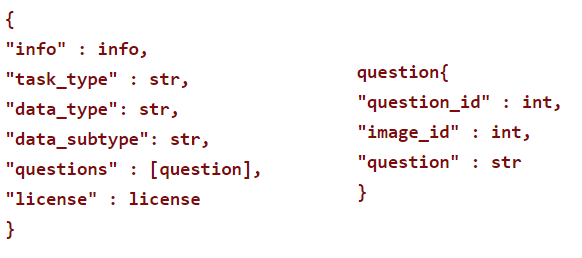

```
quest['question'] >>> 
What is this photo taken looking through?

regex.findall(quest['question'].lower()) >>> 
[' ', ' ', ' ', ' ', ' ', ' ', '?']

regex.split(quest['question'].lower()) >>> 
['what', 'is', 'this', 'photo', 'taken', 'looking', 'through', '']
```



**len(q_data ['questions']) == 10739**

**q_data ['questions'][0]**
```
{
  'image_id': 262144, 
  'question': 'What credit card company is on the banner in the background?',
  'question_id': 262144005
}
```



In [ ]:
def make_a_vocab(top_answer):

  answers = defaultdict(lambda :0)
  dataset = os.listdir(src_dir + '/Annotations')

  for file in dataset:
    path = os.path.join(src_dir, 'Annotations', file)

    try:
      with open(path, 'r') as f:
        data = json.load(f)
    except(IOError, SyntaxError):
      break

    annotations = data['annotations']
    for entry in annotations:
      vocab = entry['multiple_choice_answer']
      if re.search(r'[^\w\s]', vocab): 
        continue
      answers[vocab] += 1

  # sort by max value to keep top-1000-answers occuring
  answers = sorted(answers, key=answers.get, reverse=True)
  # adding the <unk> answer as the first element in our answer-vocab
  top_answers = ['<unk>'] + answers[:top_answer-1]
  with open(des_dir + '/Annotations/annotation_vocabs.txt', 'w') as f :
    f.writelines([ans+'\n' for ans in top_answers])

  print(f'The number of total words of answers: {len(answers)}')
  print(f'Keep top {top_answers} answers into vocab' )

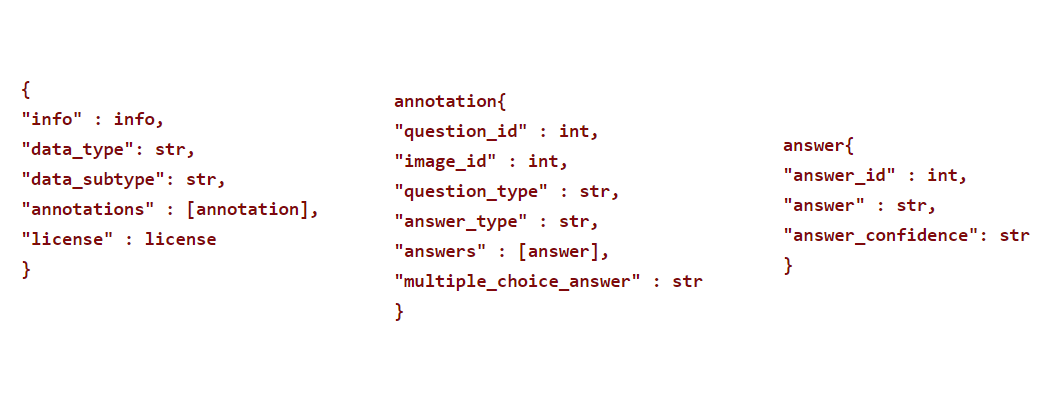

```
{
  'question_type': 'what is this', 
  'multiple_choice_answer': 'net', 
  'answers': 
  [
  {'answer': 'net', 'answer_confidence': 'maybe', 'answer_id': 1},  
  {'answer': 'net', 'answer_confidence': 'yes', 'answer_id': 2}, 
  {'answer': 'net', 'answer_confidence': 'yes', 'answer_id': 3}, 
  {'answer': 'netting', 'answer_confidence': 'yes', 'answer_id': 4}, 
  {'answer': 'net', 'answer_confidence': 'yes', 'answer_id': 5}, 
  {'answer': 'net', 'answer_confidence': 'yes', 'answer_id': 6}, 
  {'answer': 'mesh', 'answer_confidence': 'maybe', 'answer_id': 7}, 
  {'answer': 'net', 'answer_confidence': 'yes', 'answer_id': 8}, 
  {'answer': 'net', 'answer_confidence': 'yes', 'answer_id': 9}, 
  {'answer': 'net', 'answer_confidence': 'yes', 'answer_id': 10}
  ], 
  'image_id': 458752, 
  'answer_type': 'other', 
  'question_id': 458752000
} 
```

In [ ]:
if __name__ == "__main__":
  make_q_vocab()
  make_a_vocab(top_answer)

<_io.TextIOWrapper name='/content/dataset/original/Questions/v2_OpenEnded_mscoco_test-dev2015_questions.json' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/dataset/original/Questions/v2_OpenEnded_mscoco_test2015_questions.json' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/dataset/original/Questions/v2_OpenEnded_mscoco_val2014_questions.json' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/dataset/original/Questions/v2_OpenEnded_mscoco_train2014_questions.json' mode='r' encoding='UTF-8'>
total word:17777
The number of total words of answers: 26480
Keep top ['<unk>', 'yes', 'no', '1', '2', 'white', '3', 'blue', 'red', 'black', '0', '4', 'brown', 'green', 'yellow', '5', 'gray', 'right', 'nothing', 'frisbee', 'left', 'baseball', 'tennis', '6', 'orange', 'none', 'wood', 'pizza', 'bathroom', 'pink', 'kitchen', '10', '8', 'cat', '7', 'man', 'water', 'grass', 'dog', 'skiing', 'skateboarding', 'black and white', 'kite', 'surfing', 'silver', 'horse', '

In [ ]:
import glob
import re
import json
import numpy as np
import os

In [ ]:
question_dir = '/content/dataset/original/Questions'
annotation_dir = '/content/dataset/original/Annotations'
output_dir = '/content/dataset/preprocessed'

In [ ]:
def match_top_ans(annotation_ans):
    annotation_dir = output_dir + '/Annotations/annotation_vocabs.txt'
    with open(annotation_dir, 'r') as f:
      top_ans = [line.strip() for line in f]
    if annotation_ans not in top_ans:
      annotation_ans = '<unk>'
      match_top_ans.unk_ans += 1
    return annotation_ans

In [ ]:
def preprocessing(question, annotation_dir, labeled):
  with open(question, 'r') as f:
    data = json.load(f)
    questions = data['questions']
    if (data['data_subtype'] == 'test-dev2015'):
      filename = 'test2015'
    else:
      filename = data['data_subtype']

  if labeled: # false : if the file that came from questions directory is a json test file
              # true : if val or train
    template = annotation_dir + f'/*{filename}*.json'
    annotation_path = glob.glob(template)[0]
    with open(annotation_path) as f:
      annotations = json.load(f)['annotations']
    question_dict = {ans['question_id']: ans for ans in annotations}

  match_top_ans.unk_ans = 0
  dataset = [None]*len(questions)
  for idx, qu in enumerate(questions):
    if (idx+1) % 10000 == 0:
      print(f'processing {data["data_subtype"]} data: {idx+1}/{len(questions)}')
    qu_id = qu['question_id']
    qu_sentence = qu['question']
    img_id = qu['image_id']
    img_name = 'COCO_' + filename + '_{:0>12d}.jpg'.format(img_id)

    info = [img_name, qu_sentence]
    if labeled:
        annotation_ans = question_dict[qu_id]['multiple_choice_answer']
        ans = match_top_ans(annotation_ans)
        info.append(ans)
        
    dataset[idx] = info
  print(f'total {match_top_ans.unk_ans} out of {len(questions)} answers are <unk>')
  return dataset    


In [ ]:
processed_data = {}
for file in os.listdir(question_dir):
  try:
    datatype = file[20:-19]
    print(datatype)
    labeled = False if "test" in datatype else True
    question = os.path.join(question_dir, file)
    processed_data[datatype] = preprocessing(question, annotation_dir, labeled)
    #print(processed_data.keys())
  except(IOError, SyntaxError):
    pass

print(processed_data['train'][:3])

test-dev
processing test-dev2015 data: 10000/107394
processing test-dev2015 data: 20000/107394
processing test-dev2015 data: 30000/107394
processing test-dev2015 data: 40000/107394
processing test-dev2015 data: 50000/107394
processing test-dev2015 data: 60000/107394
processing test-dev2015 data: 70000/107394
processing test-dev2015 data: 80000/107394
processing test-dev2015 data: 90000/107394
processing test-dev2015 data: 100000/107394
total 0 out of 107394 answers are <unk>
test
processing test2015 data: 10000/447793
processing test2015 data: 20000/447793
processing test2015 data: 30000/447793
processing test2015 data: 40000/447793
processing test2015 data: 50000/447793
processing test2015 data: 60000/447793
processing test2015 data: 70000/447793
processing test2015 data: 80000/447793
processing test2015 data: 90000/447793
processing test2015 data: 100000/447793
processing test2015 data: 110000/447793
processing test2015 data: 120000/447793
processing test2015 data: 130000/447793
proc

In [ ]:
for key, value in processed_data.items():
        np.save(os.path.join(output_dir, f'{key}.npy'), np.array(value))

In [ ]:
%cp -av "/content/dataset/preprocessed/test-dev.npy" "/content/drive/MyDrive/VQA_preprocessed"
%cp -av "/content/dataset/preprocessed/test.npy" "/content/drive/MyDrive/VQA_preprocessed"
%cp -av "/content/dataset/preprocessed/train.npy" "/content/drive/MyDrive/VQA_preprocessed"
%cp -av "/content/dataset/preprocessed/val.npy" "/content/drive/MyDrive/VQA_preprocessed"

'/content/dataset/preprocessed/test-dev.npy' -> '/content/drive/MyDrive/VQA_preprocessed/test-dev.npy'
'/content/dataset/preprocessed/test.npy' -> '/content/drive/MyDrive/VQA_preprocessed/test.npy'
'/content/dataset/preprocessed/train.npy' -> '/content/drive/MyDrive/VQA_preprocessed/train.npy'
'/content/dataset/preprocessed/val.npy' -> '/content/drive/MyDrive/VQA_preprocessed/val.npy'


In [ ]:
%cp -av "/content/dataset/preprocessed/Questions" "/content/drive/MyDrive/VQA_preprocessed/preprocessed"
%cp -av "/content/dataset/preprocessed/Annotations" "/content/drive/MyDrive/VQA_preprocessed/preprocessed"

'/content/dataset/preprocessed/Questions' -> '/content/drive/MyDrive/VQA_preprocessed/preprocessed/Questions'
'/content/dataset/preprocessed/Questions/.ipynb_checkpoints' -> '/content/drive/MyDrive/VQA_preprocessed/preprocessed/Questions/.ipynb_checkpoints'
'/content/dataset/preprocessed/Questions/question_vocabs.txt' -> '/content/drive/MyDrive/VQA_preprocessed/preprocessed/Questions/question_vocabs.txt'
'/content/dataset/preprocessed/Annotations' -> '/content/drive/MyDrive/VQA_preprocessed/preprocessed/Annotations'
'/content/dataset/preprocessed/Annotations/.ipynb_checkpoints' -> '/content/drive/MyDrive/VQA_preprocessed/preprocessed/Annotations/.ipynb_checkpoints'
'/content/dataset/preprocessed/Annotations/annotation_vocabs.txt' -> '/content/drive/MyDrive/VQA_preprocessed/preprocessed/Annotations/annotation_vocabs.txt'
